<a href="https://colab.research.google.com/github/nobradford/NNVisualIllusions/blob/main/ver5_ori_neural_nets_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import pandas as pd
from torchvision import models
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import io, requests
import tqdm
import scipy.ndimage as nd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import tensorflow as tf
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor

preprocess = transforms.Compose([
   transforms.ToPILImage(),
   transforms.Resize(256),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   ])

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

In [ ]:
### SMOL TEST FOLDER UPLOAD###
test_stim= drive.ListFile(
    {'q': "'1tvcuZ4ada4NiBk1XxfMv6uEnAQY7i1Nd' in parents"}).GetList()
for f in test_stim:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

Streaming output truncated to the last 5000 lines.
title: stim2_1479_76.jpeg, id: 1qMJUrYbUtKC9wTUE-2JYaVvOXbCp21nB
downloading to /root/data/stim2_1479_76.jpeg
title: stim2_1487_81.jpeg, id: 1VpMnJwA_De8CZDxE-0j4LWMakONBtjKT
downloading to /root/data/stim2_1487_81.jpeg
title: stim2_1489_22.jpeg, id: 1Rw5aTQCV4K7O028dgAu12p8PvjfSVhEC
downloading to /root/data/stim2_1489_22.jpeg
title: stim2_1484_42.jpeg, id: 1NHWiUBA4_AyYVJxTo0hj377Rl_z3z6DA
downloading to /root/data/stim2_1484_42.jpeg
title: stim2_1481_35.jpeg, id: 1E8C5y-nCGsn5102FLnqYhADrWdHNzRTL
downloading to /root/data/stim2_1481_35.jpeg
title: stim2_1483_90.jpeg, id: 1uK1OQHpKNOGYKr4dAz0pSKM5PRSbSAvJ
downloading to /root/data/stim2_1483_90.jpeg
title: stim2_1486_28.jpeg, id: 1oABxjZzK_obUzCGWfDs9VRc0n3F2_m8E
downloading to /root/data/stim2_1486_28.jpeg
title: stim2_1488_44.jpeg, id: 14zLruYuTVgof5SV9XRynd7Qiu5MIlhUR
downloading to /root/data/stim2_1488_44.jpeg
title: stim2_1480_45.jpeg, id: 15vuV9XIQyGS1ImPbKa8CvV41pFxO2Y6J
down

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## INSERT CODE TO CREATE DATASET
class test_orientations(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.test_ori_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
  def __len__(self):
    return len(self.test_ori_frame)
    
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir,
                                self.test_ori_frame.iloc[idx, 0])
    image = io.imread(img_name)
    number_objects = self.test_ori_frame.iloc[idx, 1]
    number_objects = np.array([number_objects])
    number_objects = number_objects.astype('float')#.reshape(-1, 2)
    label = self.test_ori_frame.iloc[idx, 2]
    label = np.array([label])
    label = label.astype('float')
    sample = {'image': image,'number_objects': number_objects, 'label':label}

    if self.transform:
      image = self.transform(image) 
    sample = {'image': image, 'number_objects': number_objects,'label':label} 
    return image, number_objects, label



In [ ]:
train_set = test_orientations(csv_file='drive/MyDrive/stim/train stim/train_labels1.csv',
                                    root_dir='drive/MyDrive/stim/train stim',
                                    transform=preprocess)
                                  

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)

In [ ]:
at_layer = 31
net = torchvision.models.vgg16(pretrained=True)
layers = list(net.features.children())
model = nn.Sequential(*layers[: (at_layer + 1)]).cuda()


In [ ]:
data, num_objects, target = next(iter(train_loader)) 
output = model(data.cuda())
#output of truncated network is input for linear

In [ ]:
crossentloss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

def train_step(data, target, lin, opt_fn, loss_fn):
    y = lin(data.cuda())
    loss = loss_fn(y, target.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [ ]:
output.size()

torch.Size([50, 512, 8, 8])

In [ ]:
my_module = torch.nn.Module()
C = 81
lin = torch.nn.Linear(in_features = 512*8*8, out_features = (89)).cuda() 
x = torch.zeros([10,512,8,8]).cuda()
x_flat=torch.flatten(x,1)
y = lin(x_flat)


In [ ]:
acc_hist_train = []
acc_hist_test = []
acc_batch = []
for epoch in range(200):
  lin.train()
  
  for data,num_objects, target in tqdm.tqdm(iter(train_loader)):
    output=model(data.cuda())
    flattenedoutput = torch.flatten(output.detach(),1)
    y = lin(flattenedoutput)
    loss = crossentloss(y, target.squeeze().long().cuda())
    loss.backward()
    opt.step()
    opt.zero_grad()

  acc_batch.append(torch.mean((target.cuda() == y.argmax(1)).float()))
acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))  


100%|██████████| 61/61 [00:37<00:00,  1.62it/s]


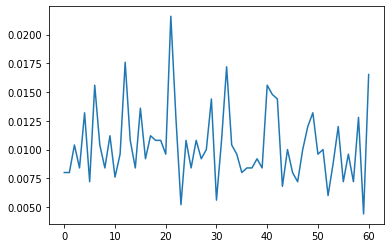

In [ ]:
plt.plot(acc_batch)

In [ ]:
print(acc_hist_train)

[tensor(0.0104)]


In [ ]:
test_stim= drive.ListFile(
    {'q': "'1RuJn4yXvPKEkK5GEefgdfzeiqwHzJZmN' in parents"}).GetList()
for f in test_stim:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

KeyboardInterrupt: ignored

In [ ]:
test_set = test_orientations(csv_file='drive/MyDrive/stim/test_stim/test_stim_labels1.csv',
                                    root_dir='drive/MyDrive/stim/test_stim',
                                    transform=preprocess)
                                  

test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=False)

In [ ]:
data, num_objects, target = next(iter(test_loader)) 
output = model(data.cuda())

In [ ]:
acc_batch = []
acc_hist_train = []
acc_hist_test = []
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler
subset_loader = torch.utils.data.DataLoader(train_set, batch_size=50, sampler=SubsetRandomSampler(range(200)))


for epoch in range(20):
  lin.train()
  for data, num_objects, target in iter(subset_loader):   
    loss_ = train_step(data, num_objects, target, lin, opt, crossentloss)

  acc_batch = []
  for data, num_objects, target in tqdm.tqdm(iter(subset_loader)):
    output=model(data.cuda())
    flattenedoutput = torch.flatten(output.detach(),1)
    y = lin(flattenedoutput)
    loss = crossentloss(y, target.squeeze().long().cuda())
    loss.backward()
    opt.step()
    opt.zero_grad()
    acc_batch.append(torch.mean((target.cuda() == y.argmax(1)).float()))
  acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))  

  acc_batch = []
  lin.eval()
  for data, num_objects, target in tqdm.tqdm(iter(test_loader)):
    output=model(data.cuda())
    flattenedoutput = torch.flatten(output.detach(),1)
    y = lin(flattenedoutput)
    loss = crossentloss(y, target.squeeze().long().cuda())
    #loss.backward()
    #opt.step()
    #opt.zero_grad()
    acc_batch.append(torch.mean((target.cuda() == y.argmax(1)).float()))
  acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch)))
  print('Accuracy:', torch.mean(torch.FloatTensor(acc_batch)))



RuntimeError: ignored

In [ ]:
print(acc_hist_test)

[tensor(0.0117)]


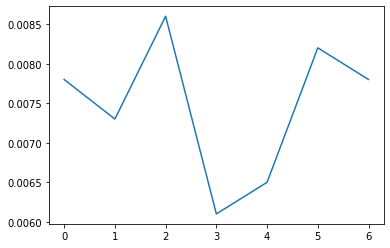

In [ ]:
#plt.plot(acc_hist_test)
plt.plot(acc_hist_train)